## Uploading dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from typing import Dict, List, Tuple

# Constants
RANDOM_STATE = 12345
RMSE_THRESHOLD = 48
TEST_SET_SHARE = 0.1
CV_FOLDS = 5

# Setting visuals
sns.set_theme()

We have time series data so we should specify a column with dates as index of the DataFrame, which we will also have to sort in order to be time-consistent.

In [2]:
taxi_data = pd.read_csv("taxi.csv", parse_dates=[0], index_col=[0])

taxi_data.sort_index(inplace=True)

taxi_data.index.is_monotonic == True

True

In [3]:
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi_data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


For forecasting we will actually need to resample the data by one hour.

In [5]:
periodicity = "1H"
taxi_data_resampled = taxi_data.resample(periodicity).sum()

taxi_data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Summary**

This initial section enables us to set up all necessary libraries and load the data, which has been correctly saved in the DataFrame and resampled by 1 hour.

## Data analysis

In [6]:
taxi_data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There seem to be no missing values in the DataFrame containing only one `num_orders` column (number of taxi orders). Additionally, we can see data correctly resampled by hour and having `DatetimeIndex`. Now, let's look at how numbers of orders are distributed.

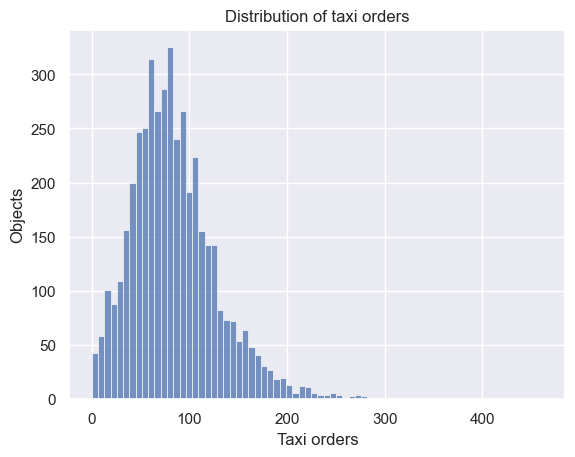

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,462.0


In [7]:
histogram = sns.histplot(data=taxi_data_resampled, x="num_orders")
histogram.set(
    title="Distribution of taxi orders",
    xlabel="Taxi orders",
    ylabel="Objects",
)
plt.show()

taxi_data_resampled.describe().round(2).T

We can also visualize the data in a slightly different way - as a time series. For that, we will write a function called `plot_time_series()` that will display time series graph of the data for specific time period with a possibility to decompose time series and plot its components.

In [8]:
def plot_time_series(
    data: pd.DataFrame,
    col: str,
    period_start: str = taxi_data_resampled.index.min(),
    period_end: str = taxi_data_resampled.index.max(),
    kind=None,
) -> None:
    """Plots time series.

    When specifying kind="decomposed", conducts seasonal decomposition
    of the data and outputs graphs of trend, seasonal and residual
    components.

    Args:
        data:
            DataFrame with information
            about taxi orders.
        col:
            DataFrame column containing
            data about taxi orders.
        period_start:
            Time period start.
        period_end:
            Time period end.
        kind:
            Boolean indicator of
            decomposing time series.

    Returns:
        None.
    """
    # Plotting decomposed time series
    if kind == "decomposed":
        decomposed = seasonal_decompose(data)

        plt.figure(figsize=(8, 10))

        # Trend component
        plt.subplot(311)
        trend_plot = sns.lineplot(
            data=decomposed.trend[period_start:period_end], ax=plt.gca()
        )
        trend_plot.set(title="Trend", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        # Seasonal component
        plt.subplot(312)
        seasonal_plot = sns.lineplot(
            data=decomposed.seasonal[period_start:period_end], ax=plt.gca()
        )
        seasonal_plot.set(title="Seasonality", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        # Residual component
        plt.subplot(313)
        residual_plot = sns.lineplot(
            data=decomposed.resid[period_start:period_end], ax=plt.gca()
        )
        residual_plot.set(title="Residual", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return

    # Plotting time series
    full_data_plot = sns.lineplot(
        data=data[period_start:period_end],
        y=col,
        x=data[period_start:period_end].index,
        ax=plt.gca(),
    )
    full_data_plot.set(
        title="Taxi orders number", xlabel="Time period", ylabel="Orders"
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

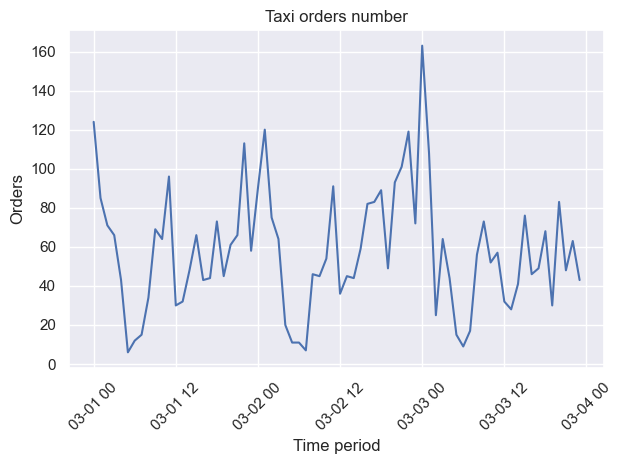

In [9]:
plot_time_series(
    data=taxi_data_resampled,
    col="num_orders",
    period_start="2018-03-01",
    period_end="2018-03-03",
)

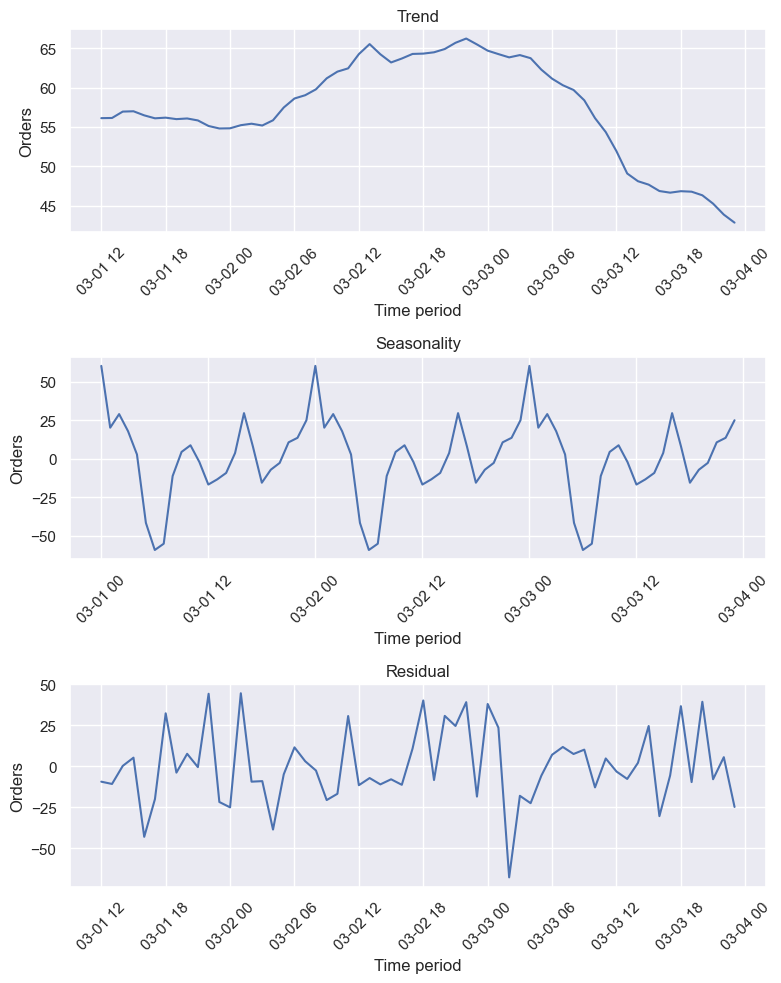

In [10]:
plot_time_series(
    data=taxi_data_resampled,
    col="num_orders",
    period_start="2018-03-01",
    period_end="2018-03-03",
    kind="decomposed",
)

We see here that there is a certain periodicity in taxi orders: every day at about 6 o'clock in the morning, orders reach their minimum and then grow, fluctuating, until reaching their maximum at midnight, after which the pattern repeats again. This fact makes us think about the possibility of the value of hours having an impact on the number of orders.

**Summary**

This stage was devoted to data visualization, where we were able to decompose the time series into three components: trend, seasonality and residual. The function we have written enabled us to visualize any period of time within the time series period as well as display the results of the seasonal decomposition of the series.

## Features extraction and preparation

Now let's move on to data preparation. To begin with, we need to actually create a dataset so that it can then be passed on to machine learning algorithms, because we have only one column, which is also a target feature. What we can do is create time variables from the DataFrame index itself, and also introduce lag values of the target attribute and a moving average as features. For that, we will write a class `FeaturesExtractor` which will inherit from `sklearn.base.BaseEstimator` and `sklearn.base.TransformerMixin`.

In [11]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):
    """Implements feature engineering for time series DataFrame.

    Attributes:
        max_lag:
            Maximum lag order of
            target column.
        rolling_mean_order:
            Order of moving average
            process.
    """

    def __init__(
        self,
        max_lag: int = 1,
        rolling_mean_order: int = 1,
    ) -> None:
        """Constructor for FeaturesExtractor class."""
        self.max_lag = max_lag
        self.rolling_mean_order = rolling_mean_order

    def fit(self, x: pd.DataFrame, y=None) -> None:
        """Returns the object itself."""
        return self

    def transform(self, x: pd.DataFrame, y=None) -> pd.DataFrame:
        """Extracts features from DateTimeIndex in accordance
        with arguments passed to __init__.

        Args:
            x:
                DataFrame with time series.
        Returns:
            Object of pd.DataFrame type which has been transformed.
        """
        X = x.copy()
        # Adding time variables
        X["quarter"] = X.index.quarter
        X["month"] = X.index.month
        X["day"] = X.index.day
        X["hour"] = X.index.hour
        # Adding lags
        for lag in range(1, self.max_lag + 1):
            X["lag_{}".format(lag)] = X["num_orders"].shift(lag)
        # Adding moving average
        X["rolling_mean_{}".format(self.rolling_mean_order)] = (
            X["num_orders"].shift().rolling(self.rolling_mean_order).mean()
        )

        return X

In [12]:
features_extractor = FeaturesExtractor()
features_extractor.get_params()

{'max_lag': 1, 'rolling_mean_order': 1}

So, we see that we have successfully created a class object and its parameters were initialized with their default values. 

Everything is fine, but the question arises about which parameters it would be better to set for the class object, because the final quality of the models will depend on this. We will proceed as follows: first, we will create a grid `dataset_size_setter` with all possible and reasonable values for class parameters.

In [13]:
dataset_size_setter = {
    "max_lag": np.arange(1, 5),
    "rolling_mean_order": np.arange(1, 5),
}
dataset_size_setter

{'max_lag': array([1, 2, 3, 4]), 'rolling_mean_order': array([1, 2, 3, 4])}

Now, we can actually convert this dictionary of arrays into a list of dictionaries with keys initialized by all possible combinations of parameter values.

In [14]:
keys, values = zip(*dataset_size_setter.items())
config_list = [dict(zip(keys, v)) for v in product(*values)]
config_num = len(config_list)
print(f"Number of model configurations: {config_num:,}")

Number of model configurations: 16


In [15]:
config_list

[{'max_lag': 1, 'rolling_mean_order': 1},
 {'max_lag': 1, 'rolling_mean_order': 2},
 {'max_lag': 1, 'rolling_mean_order': 3},
 {'max_lag': 1, 'rolling_mean_order': 4},
 {'max_lag': 2, 'rolling_mean_order': 1},
 {'max_lag': 2, 'rolling_mean_order': 2},
 {'max_lag': 2, 'rolling_mean_order': 3},
 {'max_lag': 2, 'rolling_mean_order': 4},
 {'max_lag': 3, 'rolling_mean_order': 1},
 {'max_lag': 3, 'rolling_mean_order': 2},
 {'max_lag': 3, 'rolling_mean_order': 3},
 {'max_lag': 3, 'rolling_mean_order': 4},
 {'max_lag': 4, 'rolling_mean_order': 1},
 {'max_lag': 4, 'rolling_mean_order': 2},
 {'max_lag': 4, 'rolling_mean_order': 3},
 {'max_lag': 4, 'rolling_mean_order': 4}]

Let's choose some configuration (number 7, for example) and create the dataset.

In [16]:
config_idx = 6
config_selected = config_list[config_idx]
config_selected

{'max_lag': 2, 'rolling_mean_order': 3}

In [17]:
features_extractor = features_extractor.set_params(**config_selected)
features_extractor.get_params()

{'max_lag': 2, 'rolling_mean_order': 3}

In [18]:
taxi_dataset = features_extractor.fit_transform(taxi_data_resampled)
taxi_dataset.head()

,num_orders,quarter,month,day,hour,lag_1,lag_2,rolling_mean_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,3,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,1,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,1,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,1,4,66.0,71.0,74.000000


We can now see that all four time variables have been created in addition to two lagged columns of `num_orders` as well as moving average of order 3.

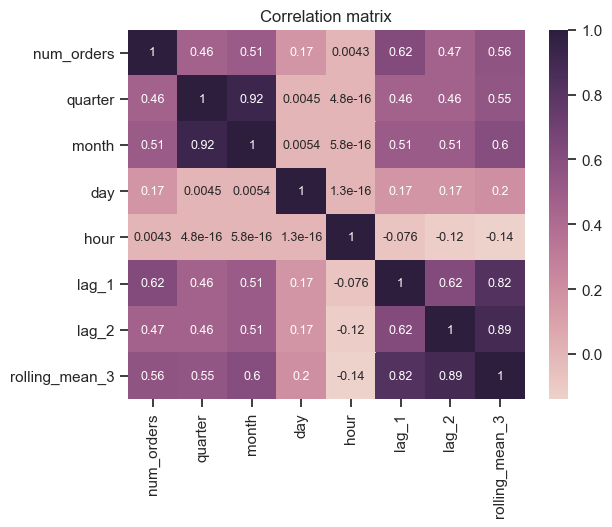

In [19]:
# Correlation matrix heatmap
corr_matrix = taxi_dataset.corr()
corr_heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    annot_kws={"size": len(taxi_dataset.columns) + 1},
    cmap=sns.cubehelix_palette(as_cmap=True),
)
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Correlation matrix")
plt.show()

The dataset has been successfully created and we see that many of the features are correlated with the target variable. Of course, `hour` column does not correlate well with the number of orders, but still the correlation does not imply causality, so we will leave it intact in the DataFrame and see later how important it will be for prediction.

Lastly, let's separate the dataset into training and testing sets by a means of `split_data()` function defined below.

In [20]:
def split_data(
    data: pd.DataFrame,
    target_name: str = "num_orders",
    test_set_size: float = TEST_SET_SHARE,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """Separates data into training and test sets.

    Args:
        data:
            DataFrame to be split.
        target_name:
            Target feature name.
        test_set_size:
            Share of testing set.

    Returns:
        Two objects of pd.DataFrame type (DataFrame of
        features for training and test sets) as well as
        two pd.Series objects (target-vectors for the two
        sets).
    """
    # Data split
    training_set, test_set = train_test_split(
        data, shuffle=False, test_size=test_set_size
    )

    # Droppings nans due to lags
    training_set = training_set.dropna()

    # Separating features from target
    features_train = training_set.drop([target_name], axis=1)
    target_train = training_set[target_name]

    features_test = test_set.drop([target_name], axis=1)
    target_test = test_set[target_name]

    return features_train, target_train, features_test, target_test

In [21]:
features_train, target_train, features_test, target_test = split_data(data=taxi_dataset)

In [22]:
features_train.shape, target_train.shape

((3971, 7), (3971,))

In [23]:
features_test.shape, target_test.shape

((442, 7), (442,))

**Summary**

At this stage, we were able to prepare data for machine learning algorithms. In particular, we were able to create a dataset by extracting features from the dataframe index and its data, and also divided the data into samples.

## Hyperparameter tuning

Now we move on to training models, which we will do by selecting hyperparameters. Consider the following regression models:

1. `DecisionTreeRegressor()`
2. `RandomForestRegressor()`
3. `CatBoostRegressor()`
4. `XGBRegressor()`
5. `LGBMRegressor()`

To select optimal combinations of hyperparameters, we will write a wrapper `HyperparamsOptimizer` for `GridSearchCV` with an opportunity to additionally generate hyperparameter tuning results in the DataFrame format.

In [24]:
class HyperparamsOptimizer(GridSearchCV):
    """Wrapper for GridSearchCV class."""

    def __init__(self, estimator, param_grid, **kwargs):
        super().__init__(estimator, param_grid, **kwargs)

    def __call__(self, top_five_iters: bool = False) -> pd.DataFrame:
        cv_results_df = pd.DataFrame(self.cv_results_)

        relevant_columns = (
            list(cv_results_df.columns[cv_results_df.columns.str.startswith("param_")])
            + ["mean_train_score"]
            + ["mean_test_score"]
        )
        cv_results_df = cv_results_df[relevant_columns]

        cv_results_df["mean_train_score"] = -cv_results_df["mean_train_score"]
        cv_results_df["mean_test_score"] = -cv_results_df["mean_test_score"]

        cv_results_df.columns = cv_results_df.columns.str.replace("param_", "")
        cv_results_df = cv_results_df.round(4)

        cv_results_df = cv_results_df.rename(
            columns={"mean_train_score": "RMSE_train", "mean_test_score": "RMSE_valid"}
        )

        if top_five_iters:
            cv_results_df = cv_results_df.sort_values(by="RMSE_valid").head()

        return cv_results_df

Additionally, we will define a separate function for plotting the results of tuning.

In [25]:
def plot_tuning(results: pd.DataFrame, model_name: str) -> None:
    """Plots results of cross-validation as barplots."""
    # Setting the figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    fig.suptitle(f"Hyperparameter tuning ({model_name})")
    # Plotting results for Decision Tree
    if "n_estimators" not in results.columns:
        for ax, m in zip(axes, ["RMSE_train", "RMSE_valid"]):
            rmse = sns.barplot(data=results, x="max_depth", y=m, ax=ax)
            rmse.set(title=m.replace("_", "-"), ylabel=None)
        plt.tight_layout()
        plt.show()
    # Plotting results for other models
    else:
        for ax, m in zip(axes, ["RMSE_train", "RMSE_valid"]):
            rmse = sns.barplot(
                data=results, x="max_depth", y=m, hue="n_estimators", ax=ax
            )
            rmse.set(title=m.replace("_", "-"), ylabel=None)
        plt.tight_layout()
        plt.show()

Since we deal with time series data, we will use an appropriate cross-validator.

In [26]:
tscv = TimeSeriesSplit(n_splits=CV_FOLDS, test_size=target_test.shape[0])

### Parameter grids

In [27]:
decision_tree_params_grid = {"max_depth": np.arange(1, 15)}

In [28]:
random_forest_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 50, 10),
}

In [29]:
catboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 50, 10),
}

In [30]:
xgboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 50, 10),
}

In [31]:
lgbm_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 50, 10),
}

### Models

In [32]:
decision_tree_model = DecisionTreeRegressor(random_state=12345)

In [33]:
random_forest_model = RandomForestRegressor(random_state=12345)

In [34]:
catboost_model = CatBoostRegressor(verbose=0)

In [35]:
xgboost_model = XGBRegressor()

In [36]:
lgbm_model = LGBMRegressor()

### Selection

#### `DecisionTree`

In [37]:
decision_tree_results = HyperparamsOptimizer(
    estimator=decision_tree_model,
    param_grid=decision_tree_params_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
decision_tree_results.fit(features_train, target_train)

decision_tree_results(top_five_iters=True)

,max_depth,RMSE_train,RMSE_valid
6,7,19.3465,30.8343
5,6,20.9436,31.0397
8,9,15.9921,31.3697
7,8,17.7602,31.3972
4,5,22.3387,31.7670


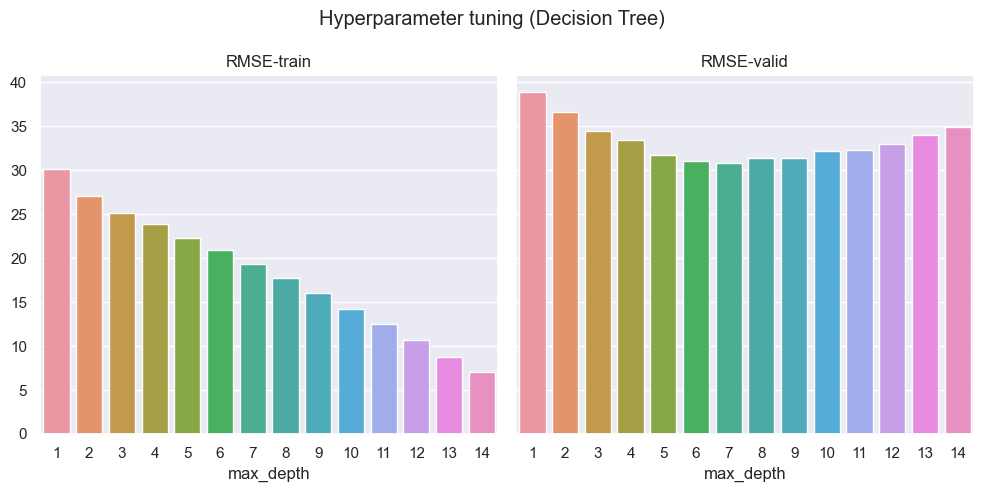

In [38]:
decision_tree_tuning = decision_tree_results()
plot_tuning(results=decision_tree_tuning, model_name="Decision Tree")

#### `RandomForest`

In [39]:
random_forest_results = HyperparamsOptimizer(
    estimator=random_forest_model,
    param_grid=random_forest_params_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
random_forest_results.fit(features_train, target_train)

random_forest_results(top_five_iters=True)

,max_depth,n_estimators,RMSE_train,RMSE_valid
23,6,40,20.0048,28.9912
22,6,30,20.0817,29.1032
21,6,20,20.1381,29.3127
20,6,10,20.2449,29.5302
19,5,40,21.4820,30.4188


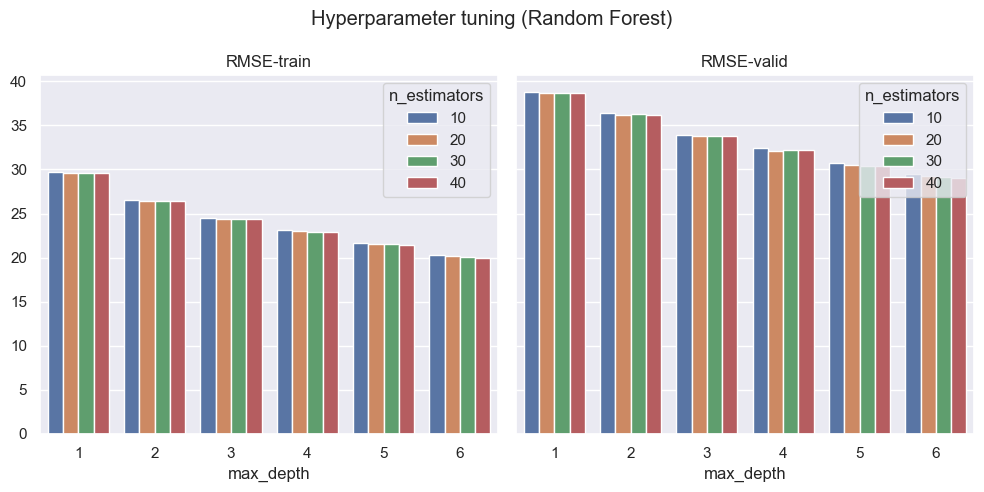

In [40]:
random_forest_tuning = random_forest_results()
plot_tuning(results=random_forest_tuning, model_name="Random Forest")

#### `Catboost`

In [41]:
catboost_results = HyperparamsOptimizer(
    estimator=catboost_model,
    param_grid=catboost_params_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
catboost_results.fit(features_train, target_train)

catboost_results(top_five_iters=True)

,max_depth,n_estimators,RMSE_train,RMSE_valid
15,4,40,17.9252,26.4651
17,5,20,18.7881,26.5099
14,4,30,18.6464,26.5474
18,5,30,17.7455,26.7326
19,5,40,16.9798,26.7837


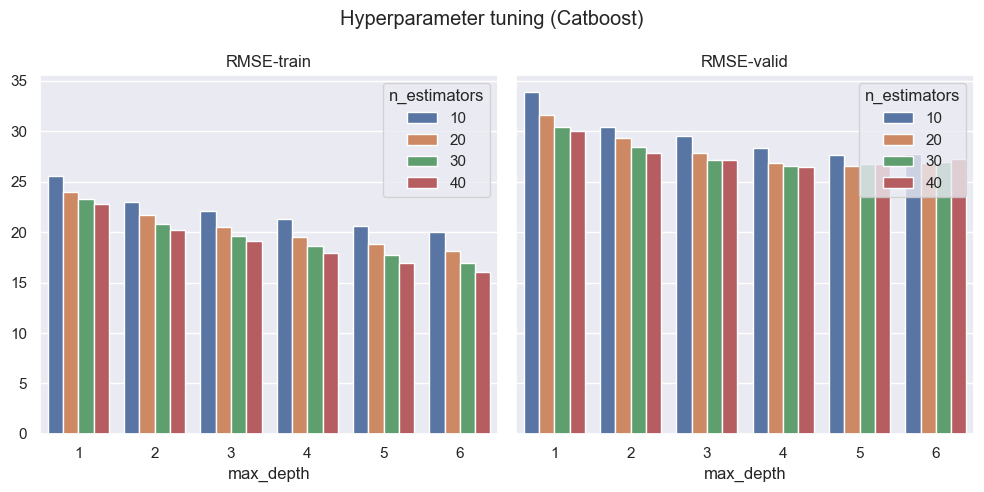

In [42]:
catboost_tuning = catboost_results()
plot_tuning(results=catboost_tuning, model_name="Catboost")

#### `XGBoost`

In [43]:
xgboost_results = HyperparamsOptimizer(
    estimator=xgboost_model,
    param_grid=xgboost_params_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
xgboost_results.fit(features_train, target_train)

xgboost_results(top_five_iters=True)

,max_depth,n_estimators,RMSE_train,RMSE_valid
11,3,40,17.9501,26.7804
10,3,30,18.5795,26.9818
15,4,40,15.9530,27.0962
17,5,20,15.8875,27.1484
14,4,30,16.7502,27.1504


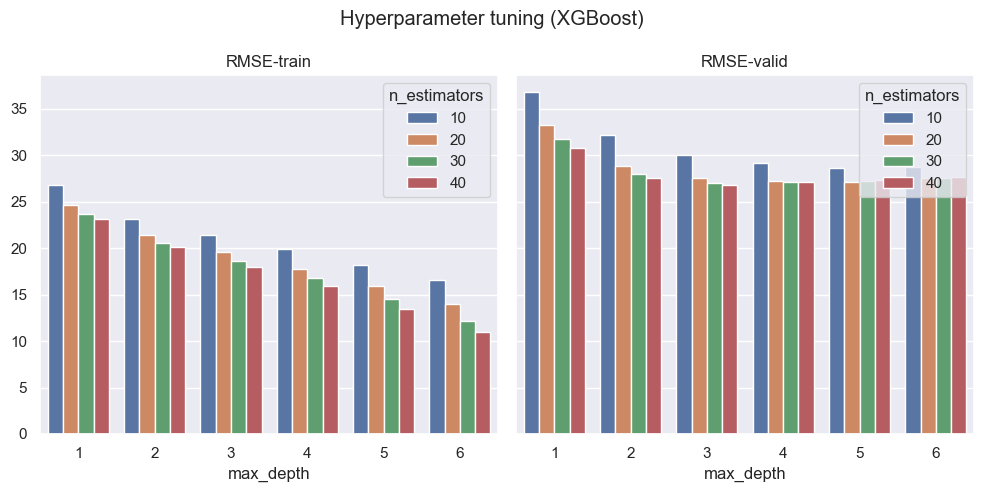

In [44]:
xgboost_tuning = xgboost_results()
plot_tuning(results=xgboost_tuning, model_name="XGBoost")

#### `LGBM`

In [45]:
lgbm_results = HyperparamsOptimizer(
    estimator=lgbm_model,
    param_grid=lgbm_params_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
lgbm_results.fit(features_train, target_train)

lgbm_results(top_five_iters=True)

,max_depth,n_estimators,RMSE_train,RMSE_valid
23,6,40,17.1480,26.7393
19,5,40,18.0515,27.0200
22,6,30,17.9157,27.2794
15,4,40,19.2357,27.6687
18,5,30,18.8241,27.7160


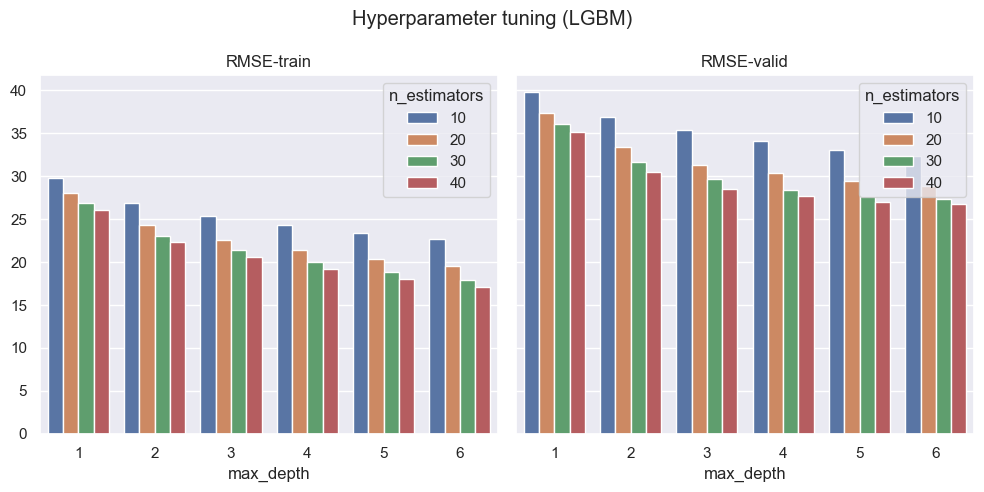

In [46]:
lgbm_tuning = lgbm_results()
plot_tuning(results=lgbm_tuning, model_name="LGBM")

## Model analysis

In [47]:
model_names = [
    type(decision_tree_results.best_estimator_).__name__,
    type(random_forest_results.best_estimator_).__name__,
    type(catboost_results.best_estimator_).__name__,
    type(xgboost_results.best_estimator_).__name__,
    type(lgbm_results.best_estimator_).__name__,
]

hyperparameters = [
    decision_tree_results.best_params_,
    random_forest_results.best_params_,
    catboost_results.best_params_,
    xgboost_results.best_params_,
    lgbm_results.best_params_,
]

final_comparison_df = pd.DataFrame(data=hyperparameters, index=model_names)

final_comparison_df["RMSE"] = [
    -decision_tree_results.best_score_,
    -random_forest_results.best_score_,
    -catboost_results.best_score_,
    -xgboost_results.best_score_,
    -lgbm_results.best_score_,
]
final_comparison_df = final_comparison_df.round(2)

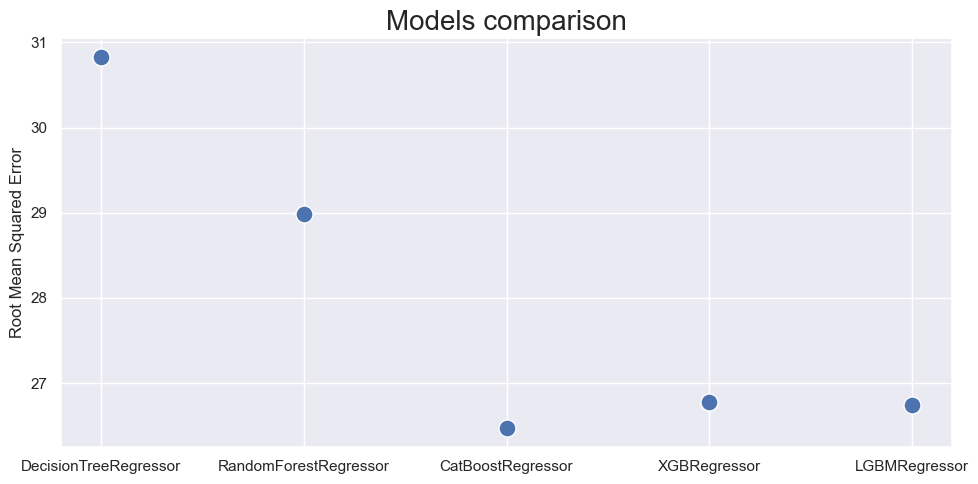

In [48]:
# Comparison of models in a plot
plt.figure(figsize=(10, 5))
comparison = sns.scatterplot(
    data=final_comparison_df,
    x=final_comparison_df.index,
    y=final_comparison_df["RMSE"],
    s=150,
)
plt.ylabel("Root Mean Squared Error")
plt.title("Models comparison", fontsize=20)
plt.tight_layout()
plt.show()

In [49]:
# Dynamically selecting the best model
grids = (
    decision_tree_results,
    random_forest_results,
    catboost_results,
    xgboost_results,
    lgbm_results,
)

final_score = np.Inf
final_grid = None
for grid in grids:
    score = -grid.best_score_
    if score < final_score:
        final_score = score
        final_grid = grid

final_model = final_grid.best_estimator_
final_comparison_df.loc[type(final_model).__name__]

max_depth        4.00
n_estimators    40.00
RMSE            26.47
Name: CatBoostRegressor, dtype: float64

**Summary**

The results of hyperparameter tuning showed that it would be reasonable to select *Catboost* model.

## Testing

In [50]:
predictions_test = final_model.predict(features_test)
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

assert rmse_test < RMSE_THRESHOLD, "Model quality is insufficient"

print(f"Test score: {rmse_test:.4f}")

Test score: 46.5618


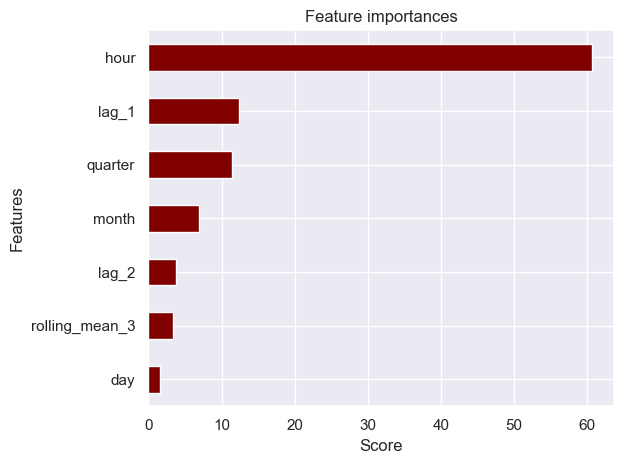

In [51]:
# Plotting feature importance
feature_importances = pd.Series(
    final_model.feature_importances_, index=features_train.columns
).sort_values()

feature_importances.plot(kind="barh", color="maroon")

plt.title("Feature importances")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [52]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(predictions_dummy, target_test, squared=False)

assert rmse_test < rmse_dummy, "Model is inadequate"

print("Model is adequate")

Model is adequate


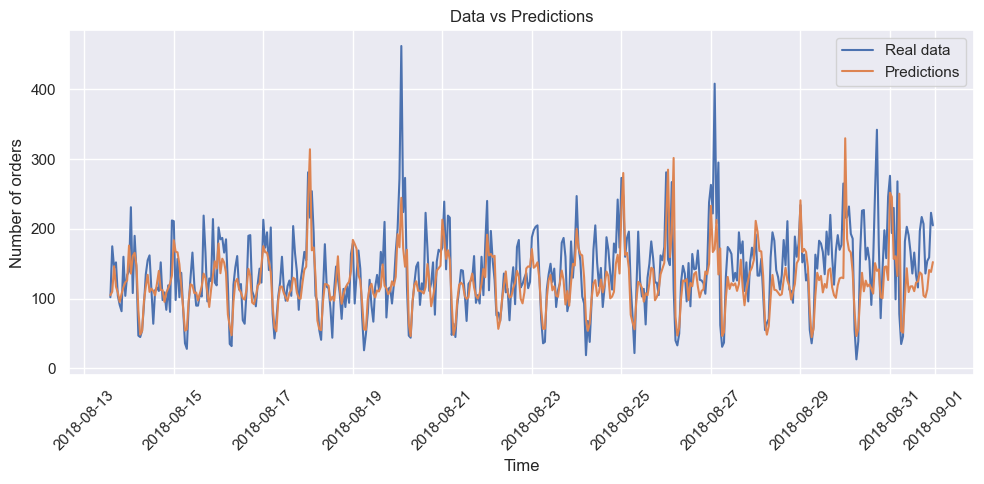

In [53]:
predictions = pd.Series(
    predictions_test, index=target_test.index, name="num_orders_predicted"
)
predictions_comparison = pd.concat([target_test, predictions], axis=1)
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders",
    label="Real data",
)
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders_predicted",
    label="Predictions",
)
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of orders")
plt.xlabel("Time")
plt.title("Data vs Predictions")
plt.tight_layout()
plt.show()

**Summary**

Testing showed that the chosen model indeed passes both quality and adequacy checks. 

## General conclusion

This study was devoted to developing of a time series forecasting model, where the data was the number of orders at the airport. During the analysis, we visualized and analyzed the data. The data was also prepared by creating additional features for machine learning. During the training of models, we were able to choose the optimal combinations of hyperparameters for each of the models under consideration, the best of which, according to the test value of the metric *RMSE*, turned out to be *CatBoostRegressor*. It was also additionally established that hours are a particularly important factor in predicting order values.